In [1]:
from lib.gamearg import *
import clingo
from IPython.display import display, Image

## Enforement Algorithm Definition

In [2]:
def generate_predicate_strings(df, pw_keyword):
    try:
        predicate_strings = []
        for _, row in df.iterrows():
            node_value = row['node']
            node_status = row [pw_keyword]
            predicate_string = f':- not len("{node_status}",{node_value},_).'
            predicate_strings.append(predicate_string)
        return predicate_strings
    except:
        raise ValueError(f"{pw_keyword} does not exist in the DataFrame")


def get_min_changes(input_file, pw_keyword, keyword="arg", reverse=False):
    wfs_stb_pws, df_wfs_stb=node_stb_cal(input_file, keyword, reverse)
    enforce_log="""

    node(X) :- attacks(X,_).
    node(Y) :- attacks(_,Y).
    
    {del(X,Y)}:- attacks(X,Y).
    
    edge(X,Y):- attacks(X,Y), not del(X,Y).
    
    % ensure that the graph with removed edge is a connected graph
    e(X,Y):- edge(X,Y).
    e(X,Y):- edge(Y,X).
    connected(X,Y) :- e(X,Y).
    connected(X,Y) :- connected(X,Z), e(Z,Y).
    :- node(X), node(Y), not connected(X,Y), X!=Y.
    
    % calculate the draw, lost, won for the new graph
    #const state_max = 100. 
    win_o(S, X) :- edge(X,Y), not win_u(S,Y), next(S,_). 
    win_u(S1,X) :- edge(X,Y), not win_o(S,Y), next(S,S1).
    fg(S1,X) :- next(S,S1), not win_u(S,X), win_u(S1,X).
    fr(0,X)  :- node(X), not win_o(0,X). 
    fr(S1,X) :- next(S,S1), not final(S), win_o(S,X), not win_o(S1,X). next(0,1). 
    next(S,S1) :- fg(S,X), S1 = S+1, S < state_max.
    final(S) :- next(S,S1), not next(S1,_). 
    len("lost",X,L)   :- fr(S,X), L = 2*S.   
    len("won",X,L)    :- fg(S,X), L = 2*S-1. 
    len("draw",X,"∞") :- node(X), not len("lost",X,_), not len("won",X,_). 
    
    % ensure no draw appears in the new graph
    :- len("draw",X,"∞").

    len("accepted",X,L):- len("lost",X,L).
    len("defeated",X,L):- len("won",X,L).
    
    """+"\n".join(generate_predicate_strings(df_wfs_stb,pw_keyword)) +"\n\n#show del/2."
    ctl = clingo.Control()
    ctl.configuration.solve.models = "0"
    ctl.load(input_file)
    ctl.add("base", [], enforce_log)
    ctl.ground([("base", [])])
    output = []
    ctl.solve(on_model=lambda m: output.append(m.symbols(shown=True)))
    return(min(output, key=len))

## Example Argumentation Framework

In [3]:
%%file files/af_example.lp

attacks(l, e).
attacks(k, l).
attacks(m, n).
attacks(l, m).
attacks(n, m).
attacks(a, b).
attacks(d, f).
attacks(e, h).
attacks(e, m).
attacks(e, d).
attacks(a, c).
attacks(d, g).
attacks(c, d).
attacks(c, e).
attacks(g, d).
attacks(d, e).
attacks(m, e).
attacks(h, i).
attacks(i, j).
attacks(a, o).
attacks(d, h).

Overwriting files/af_example.lp


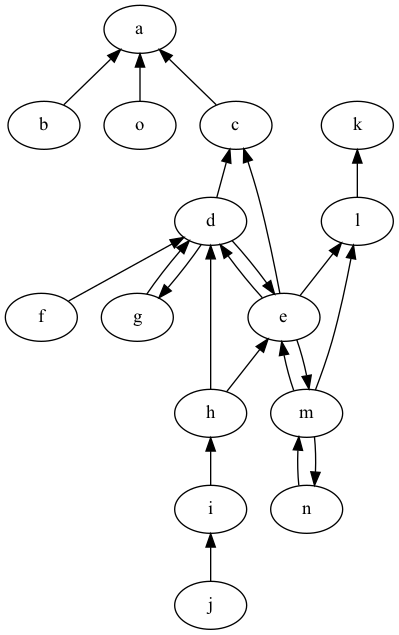

In [4]:
show_plain("files/af_example.lp")

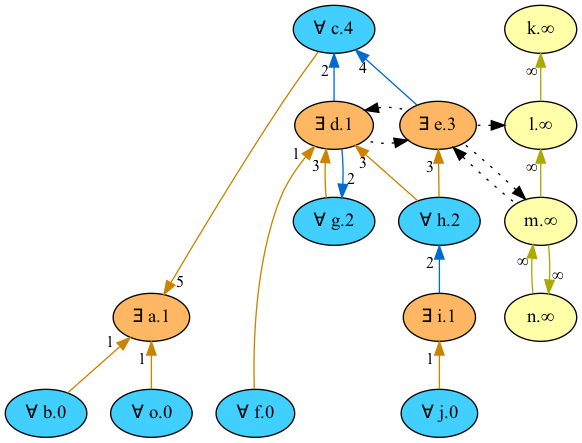

In [5]:
show_wfs("files/af_example.lp")

In [6]:
show_stb("files/af_example.lp")

In [7]:
print(get_min_changes("files/af_example.lp", "pw_1"))

[del(n,m)]


In [8]:
# print(get_min_changes("files/af_example.lp", "pw_2"))

## Modifed Argumentation Framework

Let's say if we want enforce the extension in PW_1, we can start modifying the argumentation framework by deleting `attacks(n,m)`

In [9]:
%%file files/af_enforced.lp

attacks(l, e).
attacks(k, l).
attacks(m, n).
attacks(l, m).
% attacks(n, m).
attacks(a, b).
attacks(d, f).
attacks(e, h).
attacks(e, m).
attacks(e, d).
attacks(a, c).
attacks(d, g).
attacks(c, d).
attacks(c, e).
attacks(g, d).
attacks(d, e).
attacks(m, e).
attacks(h, i).
attacks(i, j).
attacks(a, o).
attacks(d, h).

Overwriting files/af_enforced.lp


We then can calculate the well founded semantics for this modfied argumentation framework

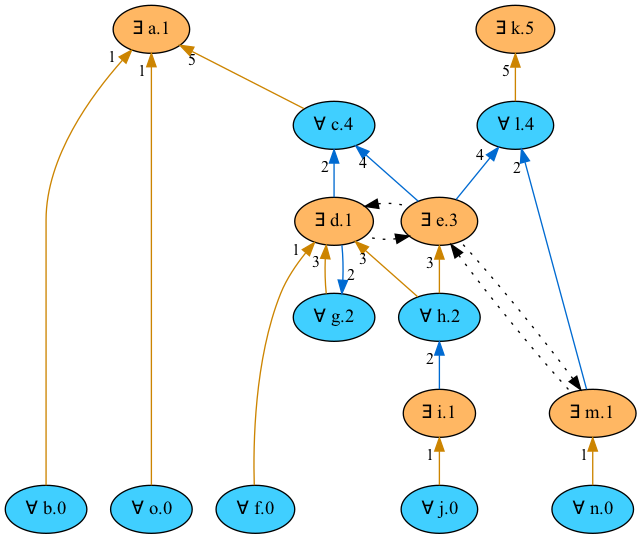

In [10]:
show_wfs("files/af_enforced.lp")